In [4]:
import torch
import torch.nn as nn
from trainer import Trainer, compute_loss_and_accuracy
#from task2 import create_plots

In [5]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import typing
import numpy as np
np.random.seed(0)


mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        #transforms.RandomHorizontalFlip(0.5),
        #transforms.RandomRotation(20),
        #transforms.RandomErasing(p=0.1)
        #transforms.RandomGrayscale(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    data_train = datasets.CIFAR10('data/cifar10',
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10('data/cifar10',
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test


In [11]:
class Model1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm2d(256),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [12]:
epochs = 10
batch_size = 64
learning_rate = 3e-2 # Should be 5e-5 for LeNet
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
model = Model1(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
)
trainer.train()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Model1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05, mo

 10%|█         | 1/10 [00:14<02:14, 14.92s/it]

Epoch: 0, Batches per seconds: 47.28, Global step:    702, Validation Loss: 1.03, Validation Accuracy: 0.624
Epoch: 1, Batches per seconds: 46.85, Global step:   1053, Validation Loss: 0.94, Validation Accuracy: 0.673


 20%|██        | 2/10 [00:29<01:59, 14.95s/it]

Epoch: 1, Batches per seconds: 47.00, Global step:   1404, Validation Loss: 0.90, Validation Accuracy: 0.681
Epoch: 2, Batches per seconds: 46.82, Global step:   1755, Validation Loss: 0.83, Validation Accuracy: 0.708


 30%|███       | 3/10 [00:44<01:44, 14.96s/it]

Epoch: 2, Batches per seconds: 46.97, Global step:   2106, Validation Loss: 0.76, Validation Accuracy: 0.731
Epoch: 3, Batches per seconds: 46.70, Global step:   2457, Validation Loss: 0.75, Validation Accuracy: 0.740


 40%|████      | 4/10 [00:59<01:29, 14.95s/it]

Epoch: 3, Batches per seconds: 47.02, Global step:   2808, Validation Loss: 0.71, Validation Accuracy: 0.756
Epoch: 4, Batches per seconds: 47.07, Global step:   3159, Validation Loss: 0.74, Validation Accuracy: 0.747


 50%|█████     | 5/10 [01:14<01:14, 14.94s/it]

Epoch: 4, Batches per seconds: 47.03, Global step:   3510, Validation Loss: 0.67, Validation Accuracy: 0.773
Epoch: 5, Batches per seconds: 46.86, Global step:   3861, Validation Loss: 0.75, Validation Accuracy: 0.776


 60%|██████    | 6/10 [01:29<00:59, 14.95s/it]

Epoch: 5, Batches per seconds: 47.02, Global step:   4212, Validation Loss: 1.06, Validation Accuracy: 0.785
Epoch: 6, Batches per seconds: 46.95, Global step:   4563, Validation Loss: 0.61, Validation Accuracy: 0.788


 70%|███████   | 7/10 [01:44<00:44, 14.96s/it]

Epoch: 6, Batches per seconds: 47.00, Global step:   4914, Validation Loss: 0.62, Validation Accuracy: 0.792
Epoch: 7, Batches per seconds: 47.05, Global step:   5265, Validation Loss: 0.57, Validation Accuracy: 0.803


 80%|████████  | 8/10 [01:59<00:29, 14.86s/it]

Epoch: 7, Batches per seconds: 47.13, Global step:   5616, Validation Loss: 0.60, Validation Accuracy: 0.796
Epoch: 8, Batches per seconds: 47.06, Global step:   5967, Validation Loss: 0.58, Validation Accuracy: 0.806
Epoch: 8, Batches per seconds: 47.13, Global step:   6318, Validation Loss: 0.62, Validation Accuracy: 0.803


 90%|█████████ | 9/10 [02:14<00:14, 14.88s/it]

Epoch: 9, Batches per seconds: 47.09, Global step:   6669, Validation Loss: 0.56, Validation Accuracy: 0.814
Epoch: 9, Batches per seconds: 47.11, Global step:   7020, Validation Loss: 0.56, Validation Accuracy: 0.813


100%|██████████| 10/10 [02:29<00:00, 14.92s/it]


In [15]:
trainer.load_best_model()
test_set = trainer.dataloader_test
val_set = trainer.dataloader_val
train_set = trainer.dataloader_train

#create_plots(trainer, "task2_1")
print(compute_loss_and_accuracy(dataloader=test_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=val_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=train_set,model = model, loss_criterion=nn.CrossEntropyLoss()))

(tensor(0.7233, device='cuda:0'), 0.7656)
(tensor(0.7092, device='cuda:0'), 0.7606)
(tensor(0.5097, device='cuda:0'), 0.8217238620199147)


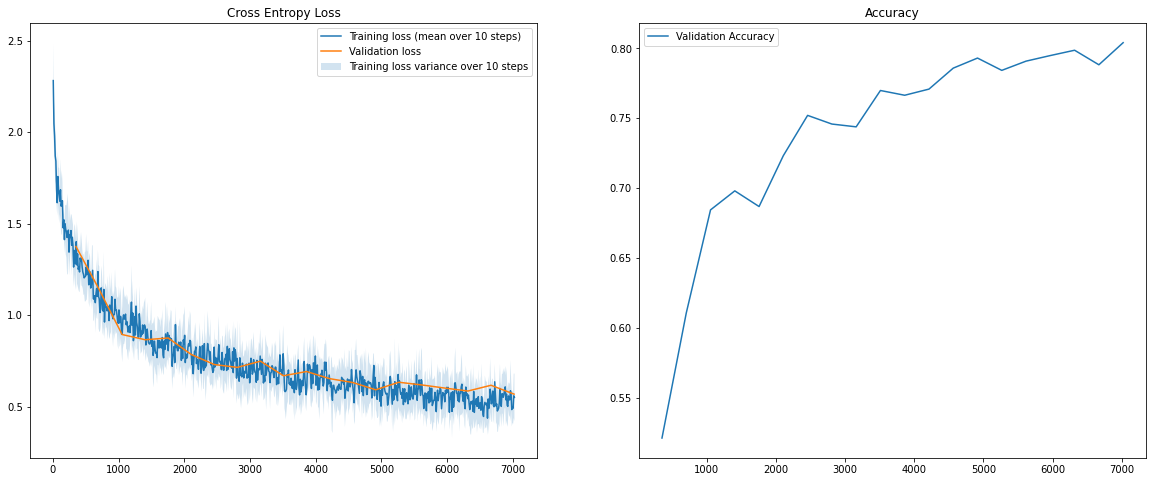

In [54]:
import matplotlib.pyplot as plt
import pathlib
import utils

def plot(task):
  plot_path = pathlib.Path("plots")
  plot_path.mkdir(exist_ok=True)
  # Save plots and show them
  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.title("Cross Entropy Loss")
  utils.plot_loss(trainer.train_history["loss"], label="Training loss", npoints_to_average=10)
  utils.plot_loss(trainer.validation_history["loss"], label="Validation loss")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.title("Accuracy")
  utils.plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
  plt.legend()
  plt.savefig(plot_path.joinpath(f"plotTask{task}.png"))
  plt.show()

plot("3c")

In [33]:
class Model2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.SiLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [34]:
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_2 = Model2(image_channels=3, num_classes=10)
trainer_2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_2,
    dataloaders,
)
trainer_2.train()

Files already downloaded and verified
Files already downloaded and verified



  0%|          | 0/10 [00:00<?, ?it/s]

Model2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05, mo


 10%|█         | 1/10 [00:14<02:06, 14.03s/it]

Epoch: 0, Batches per seconds: 50.22, Global step:    702, Validation Loss: 1.12, Validation Accuracy: 0.596
Epoch: 1, Batches per seconds: 50.09, Global step:   1053, Validation Loss: 1.04, Validation Accuracy: 0.631



 20%|██        | 2/10 [00:28<01:52, 14.05s/it]

Epoch: 1, Batches per seconds: 50.04, Global step:   1404, Validation Loss: 0.97, Validation Accuracy: 0.658
Epoch: 2, Batches per seconds: 49.86, Global step:   1755, Validation Loss: 0.88, Validation Accuracy: 0.693



 30%|███       | 3/10 [00:42<01:38, 14.11s/it]

Epoch: 2, Batches per seconds: 49.80, Global step:   2106, Validation Loss: 0.85, Validation Accuracy: 0.703
Epoch: 3, Batches per seconds: 49.74, Global step:   2457, Validation Loss: 0.80, Validation Accuracy: 0.723



 40%|████      | 4/10 [00:56<01:24, 14.05s/it]

Epoch: 3, Batches per seconds: 49.98, Global step:   2808, Validation Loss: 0.76, Validation Accuracy: 0.732
Epoch: 4, Batches per seconds: 49.78, Global step:   3159, Validation Loss: 0.82, Validation Accuracy: 0.709



 50%|█████     | 5/10 [01:10<01:10, 14.10s/it]

Epoch: 4, Batches per seconds: 49.86, Global step:   3510, Validation Loss: 0.78, Validation Accuracy: 0.731
Epoch: 5, Batches per seconds: 49.68, Global step:   3861, Validation Loss: 0.76, Validation Accuracy: 0.740



 60%|██████    | 6/10 [01:24<00:56, 14.12s/it]

Epoch: 5, Batches per seconds: 49.84, Global step:   4212, Validation Loss: 0.69, Validation Accuracy: 0.756
Epoch: 6, Batches per seconds: 49.82, Global step:   4563, Validation Loss: 0.68, Validation Accuracy: 0.768



 70%|███████   | 7/10 [01:38<00:42, 14.05s/it]

Epoch: 6, Batches per seconds: 49.93, Global step:   4914, Validation Loss: 0.78, Validation Accuracy: 0.736
Epoch: 7, Batches per seconds: 49.90, Global step:   5265, Validation Loss: 0.90, Validation Accuracy: 0.744



 80%|████████  | 8/10 [01:52<00:27, 13.98s/it]

Epoch: 7, Batches per seconds: 50.05, Global step:   5616, Validation Loss: 0.67, Validation Accuracy: 0.771
Epoch: 8, Batches per seconds: 49.99, Global step:   5967, Validation Loss: 0.65, Validation Accuracy: 0.775



 90%|█████████ | 9/10 [02:06<00:14, 14.08s/it]

Epoch: 8, Batches per seconds: 49.94, Global step:   6318, Validation Loss: 0.70, Validation Accuracy: 0.758
Epoch: 9, Batches per seconds: 49.87, Global step:   6669, Validation Loss: 0.70, Validation Accuracy: 0.769
Epoch: 9, Batches per seconds: 49.90, Global step:   7020, Validation Loss: 0.67, Validation Accuracy: 0.767



100%|██████████| 10/10 [02:20<00:00, 14.09s/it]


In [36]:
trainer_2.load_best_model()
test_set = trainer.dataloader_test
val_set = trainer.dataloader_val
train_set = trainer.dataloader_train

#create_plots(trainer, "task2_1")
print(compute_loss_and_accuracy(dataloader=test_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=val_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=train_set,model = model, loss_criterion=nn.CrossEntropyLoss()))

(tensor(0.7084, device='cuda:0'), 0.7686)
(tensor(0.7149, device='cuda:0'), 0.7638)
(tensor(0.4808, device='cuda:0'), 0.8330592105263158)


## Task 3 - multiple plots describing the best change



In [45]:
class Model3c_1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [46]:
class Model3c_2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [50]:
epochs = 10
batch_size = 64
learning_rate = 3e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_3c1 = Model3c_1(image_channels=3, num_classes=10)
trainer_3c1 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_3c1,
    dataloaders,
)
trainer_3c1.train()

Files already downloaded and verified
Files already downloaded and verified





  0%|          | 0/10 [00:00<?, ?it/s]

Model3c_1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05,




 10%|█         | 1/10 [00:14<02:07, 14.18s/it]

Epoch: 0, Batches per seconds: 49.71, Global step:    702, Validation Loss: 1.04, Validation Accuracy: 0.626
Epoch: 1, Batches per seconds: 49.59, Global step:   1053, Validation Loss: 0.92, Validation Accuracy: 0.682





 20%|██        | 2/10 [00:28<01:53, 14.21s/it]

Epoch: 1, Batches per seconds: 49.48, Global step:   1404, Validation Loss: 0.87, Validation Accuracy: 0.701
Epoch: 2, Batches per seconds: 49.30, Global step:   1755, Validation Loss: 0.95, Validation Accuracy: 0.670





 30%|███       | 3/10 [00:42<01:39, 14.16s/it]

Epoch: 2, Batches per seconds: 49.63, Global step:   2106, Validation Loss: 0.82, Validation Accuracy: 0.712
Epoch: 3, Batches per seconds: 49.63, Global step:   2457, Validation Loss: 0.79, Validation Accuracy: 0.730





 40%|████      | 4/10 [00:56<01:24, 14.15s/it]

Epoch: 3, Batches per seconds: 49.68, Global step:   2808, Validation Loss: 0.77, Validation Accuracy: 0.729
Epoch: 4, Batches per seconds: 49.55, Global step:   3159, Validation Loss: 0.67, Validation Accuracy: 0.763





 50%|█████     | 5/10 [01:10<01:10, 14.14s/it]

Epoch: 4, Batches per seconds: 49.69, Global step:   3510, Validation Loss: 0.69, Validation Accuracy: 0.765
Epoch: 5, Batches per seconds: 49.59, Global step:   3861, Validation Loss: 0.71, Validation Accuracy: 0.761





 60%|██████    | 6/10 [01:24<00:56, 14.15s/it]

Epoch: 5, Batches per seconds: 49.67, Global step:   4212, Validation Loss: 0.71, Validation Accuracy: 0.753
Epoch: 6, Batches per seconds: 49.62, Global step:   4563, Validation Loss: 0.64, Validation Accuracy: 0.775





 70%|███████   | 7/10 [01:38<00:42, 14.11s/it]

Epoch: 6, Batches per seconds: 49.74, Global step:   4914, Validation Loss: 0.67, Validation Accuracy: 0.762
Epoch: 7, Batches per seconds: 49.66, Global step:   5265, Validation Loss: 0.64, Validation Accuracy: 0.779





 80%|████████  | 8/10 [01:53<00:28, 14.12s/it]

Epoch: 7, Batches per seconds: 49.74, Global step:   5616, Validation Loss: 0.59, Validation Accuracy: 0.799
Epoch: 8, Batches per seconds: 49.67, Global step:   5967, Validation Loss: 0.61, Validation Accuracy: 0.788





 90%|█████████ | 9/10 [02:07<00:14, 14.14s/it]

Epoch: 8, Batches per seconds: 49.71, Global step:   6318, Validation Loss: 0.60, Validation Accuracy: 0.796
Epoch: 9, Batches per seconds: 49.65, Global step:   6669, Validation Loss: 0.62, Validation Accuracy: 0.789


Epoch: 9, Batches per seconds: 49.72, Global step:   7020, Validation Loss: 0.62, Validation Accuracy: 0.795


100%|██████████| 10/10 [02:21<00:00, 14.14s/it]


In [51]:
epochs = 10
batch_size = 64
learning_rate = 3e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_3c2 = Model3c_2(image_channels=3, num_classes=10)
trainer_3c2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_3c2,
    dataloaders,
)
trainer_3c2.train()

Files already downloaded and verified
Files already downloaded and verified





  0%|          | 0/10 [00:00<?, ?it/s]

Model3c_2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_feat




 10%|█         | 1/10 [00:14<02:06, 14.08s/it]

Epoch: 0, Batches per seconds: 50.07, Global step:    702, Validation Loss: 1.11, Validation Accuracy: 0.612
Epoch: 1, Batches per seconds: 49.95, Global step:   1053, Validation Loss: 0.96, Validation Accuracy: 0.673





 20%|██        | 2/10 [00:28<01:52, 14.06s/it]

Epoch: 1, Batches per seconds: 50.10, Global step:   1404, Validation Loss: 0.79, Validation Accuracy: 0.724
Epoch: 2, Batches per seconds: 49.40, Global step:   1755, Validation Loss: 0.81, Validation Accuracy: 0.720





 30%|███       | 3/10 [00:42<01:38, 14.13s/it]

Epoch: 2, Batches per seconds: 49.80, Global step:   2106, Validation Loss: 0.73, Validation Accuracy: 0.748
Epoch: 3, Batches per seconds: 49.78, Global step:   2457, Validation Loss: 0.74, Validation Accuracy: 0.750





 40%|████      | 4/10 [00:56<01:24, 14.07s/it]

Epoch: 3, Batches per seconds: 49.96, Global step:   2808, Validation Loss: 0.69, Validation Accuracy: 0.763
Epoch: 4, Batches per seconds: 49.73, Global step:   3159, Validation Loss: 0.71, Validation Accuracy: 0.766





 50%|█████     | 5/10 [01:10<01:10, 14.17s/it]

Epoch: 4, Batches per seconds: 49.72, Global step:   3510, Validation Loss: 0.72, Validation Accuracy: 0.759
Epoch: 5, Batches per seconds: 49.62, Global step:   3861, Validation Loss: 0.73, Validation Accuracy: 0.763





 60%|██████    | 6/10 [01:24<00:56, 14.13s/it]

Epoch: 5, Batches per seconds: 49.77, Global step:   4212, Validation Loss: 0.76, Validation Accuracy: 0.757
Epoch: 6, Batches per seconds: 49.75, Global step:   4563, Validation Loss: 0.80, Validation Accuracy: 0.750
Epoch: 6, Batches per seconds: 49.86, Global step:   4914, Validation Loss: 0.76, Validation Accuracy: 0.764
Early stop criteria met
Early stopping.


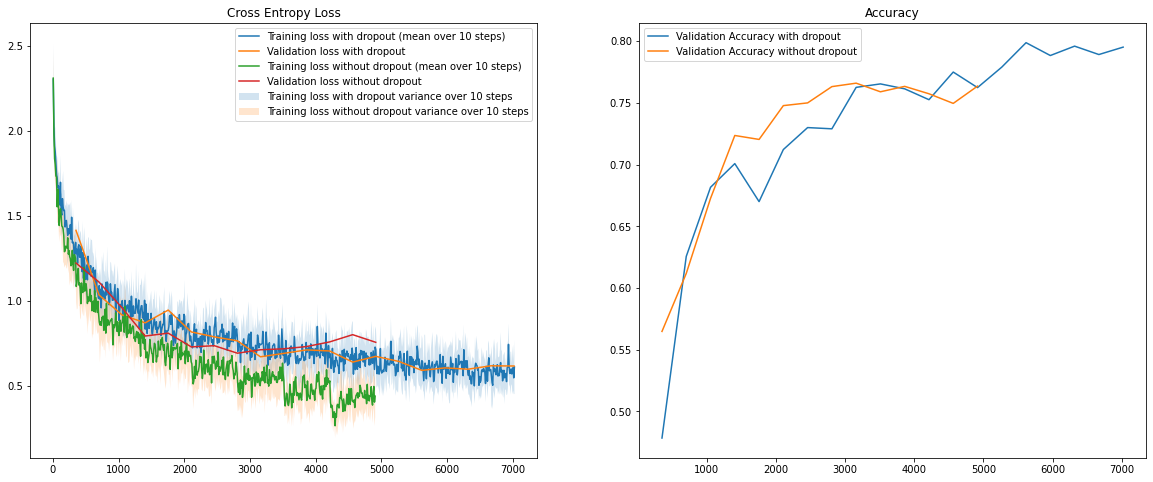

In [52]:
import pathlib
import matplotlib.pyplot as plt
import utils


plot_path = pathlib.Path("plots")
plot_path.mkdir(exist_ok=True)
# Save plots and show them
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Cross Entropy Loss")
utils.plot_loss(trainer_3c1.train_history["loss"], label="Training loss with dropout", npoints_to_average=10)
utils.plot_loss(trainer_3c1.validation_history["loss"], label="Validation loss with dropout")
utils.plot_loss(trainer_3c2.train_history["loss"], label="Training loss without dropout", npoints_to_average=10)
utils.plot_loss(trainer_3c2.validation_history["loss"], label="Validation loss without dropout")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy")
utils.plot_loss(trainer_3c1.validation_history["accuracy"], label="Validation Accuracy with dropout")
utils.plot_loss(trainer_3c2.validation_history["accuracy"], label="Validation Accuracy without dropout")

plt.legend()
plt.savefig(plot_path.joinpath("task3d.png"))
plt.show()